In [102]:
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.spatial import Delaunay

In [127]:
# Read graph data into dataframe, remove unnecessary columns, only keep december months
graph_data = pd.read_csv('san_francisco-censustracts-2017-4-All-MonthlyAggregate.csv')
graph_data = graph_data.drop(columns=['standard_deviation_travel_time', 'geometric_mean_travel_time', 'geometric_standard_deviation_travel_time'])
graph_data = graph_data.drop(graph_data[graph_data.month != 12].index)
dec_data = graph_data.drop(columns=['month'])

In [133]:
# Remove duplicates and keep the mean of duplicate travel times
dec_array = np.asarray(dec_data) # idk numpy seems easier to work with
existing_paths = {}
existing_locations = np.unique(np.concatenate([dec_array[:,0],dec_array[:,1]]))
counter = 0
for row in dec_array:
    locations = tuple(np.sort(row[0:2]))
    if locations in existing_paths:
        existing_paths[locations].append(row[2])
        counter += 1
    else:
        existing_paths[locations] = [row[2]]

In [135]:
# Write out a csv file with december data, where duplicates are averaged
# This will be used in R's igraph library to do graph analysis
with open('december_data.txt','w') as f:
    for locations in existing_paths:
        string = '{} {} {:.2f}\n'.format(int(locations[0]),int(locations[1]),np.mean(existing_paths[locations]))
        f.write(string)

In [33]:
# Load in the location data
with open('san_francisco_censustracts.json') as json_data:
    geo_data = json.load(json_data)
geo_data = geo_data['features']

In [39]:
# Process the raw data into a dictionary where key is location ID, value is display name and coordinate list
location_dictionary = {}

for entry in geo_data:
    data = {}
    # Retrieve coordinate list and compute mean coordinates
    coord_list = entry['geometry']['coordinates'][0][0]
    mean_coord = np.mean(np.asarray(coord_list),axis=0)
    movement_id = entry['properties']['MOVEMENT_ID']

    data['coord_list'] = coord_list
    data['mean_coord'] = mean_coord
    data['display_name'] = entry['properties']['DISPLAY_NAME']
    location_dictionary[movement_id] = data

In [170]:
# Load the cleaned graph data in
uber_gcc = np.loadtxt('uber_gcc.txt')
uber_gcc_graph = {}
for row in uber_gcc:
    location_index = tuple(np.sort(row[0:2]).astype('int'))
    uber_gcc_graph[location_index] = row[2]

In [122]:
uber_gcc_ids = np.concatenate([uber_gcc[:,0],uber_gcc[:,1]])
uber_gcc_ids = np.unique(uber_gcc_ids).astype('int')

mean_coords = np.zeros((len(uber_gcc_ids),2))
for n,location_key in enumerate(uber_gcc_ids):
    mean_coords[n,:] = location_dictionary[str(location_key)]['mean_coord']

In [394]:
tri = Delaunay(mean_coords)

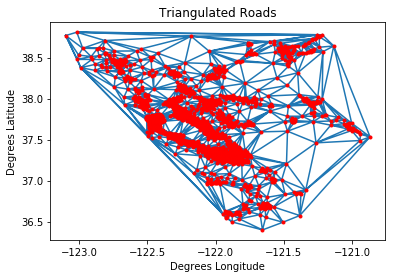

In [395]:
plt.triplot(mean_coords[:,0], mean_coords[:,1], tri.simplices.copy())
plt.plot(mean_coords[:,0], mean_coords[:,1],'r.')
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Triangulated Roads')
plt.show()

In [396]:
# Generate a new graph file that can be used in igraph to compute max flow

In [397]:
MILES_PER_DEGREE_LATLON = 69

def get_time(loc1,loc2,transit_time_graph):
    if (loc1,loc2) in transit_time_graph.keys():
        return transit_time_graph[(loc1,loc2)]
    else:
        return 0

# Calculate flow as #cars/hour
def get_flow(loc1, loc2, transit_time_graph,location_dict):
    coord1 = location_dict[str(loc1)]['mean_coord']
    coord2 = location_dict[str(loc2)]['mean_coord']
    distance_miles = MILES_PER_DEGREE_LATLON * np.sqrt(np.sum(np.square(coord2-coord1)))
    if (loc1,loc2) in transit_time_graph.keys():
        travel_time_hours = transit_time_graph[(loc1,loc2)] / 3600
        speed_mph = distance_miles / travel_time_hours
        flow = (2*speed_mph) / (0.003 + (speed_mph/1800))
        return flow
    else:
        return 0


def add_triangulated_edge(graph, triangle):
    edge12 = tuple(np.sort(triangle[:2]))
    edge13 = tuple(np.sort(triangle[0::2]))
    edge23 = tuple(np.sort(triangle[1:]))   

    flow12 = get_flow(edge12[0],edge12[1],uber_gcc_graph,location_dictionary)
    flow13 = get_flow(edge13[0],edge13[1],uber_gcc_graph,location_dictionary)
    flow23 = get_flow(edge23[0],edge23[1],uber_gcc_graph,location_dictionary)
    if edge12 not in graph.keys() and flow12 > 0:
        graph[edge12] = flow12
    if edge13 not in graph.keys() and flow13 > 0:
        graph[edge13] = flow13
    if edge23 not in graph.keys() and flow23 > 0:
        graph[edge23] = flow23

def add_travel_time_edge(graph,triangle,thresh):
    edge12 = tuple(np.sort(triangle[:2]))
    edge13 = tuple(np.sort(triangle[0::2]))
    edge23 = tuple(np.sort(triangle[1:]))   
    
    time12 = get_time(edge12[0],edge12[1],uber_gcc_graph)
    time13 = get_time(edge13[0],edge13[1],uber_gcc_graph)
    time23 = get_time(edge23[0],edge23[1],uber_gcc_graph)
    
    if edge12 not in graph.keys() and time12 < thresh and time12 > 0:
        graph[edge12] = time12
    if edge13 not in graph.keys() and time13 < thresh and time13 > 0:
        graph[edge13] = time13
    if edge23 not in graph.keys() and time23 < thresh and time23 > 0:
        graph[edge23] = time23

In [398]:
triangulated_graph = {}

for triangle_idx in tri.simplices:
    triangle = [uber_gcc_ids[triangle_idx[0]], uber_gcc_ids[triangle_idx[1]], uber_gcc_ids[triangle_idx[2]]]
    add_triangulated_edge(triangulated_graph,triangle)

In [399]:
# Write out a txt file with triangulated data
# This will be used in R's igraph library to do graph analysis
with open('triangulated_graph.txt','w') as f:
    for locations in triangulated_graph:
        string = '{} {} {:.2f}\n'.format(int(locations[0]),int(locations[1]),triangulated_graph[locations])
        f.write(string)

In [412]:
# Locate the IDs for Stanford and UCSC
for i in location_dictionary.keys():
    if location_dictionary[i]['display_name'] == '100 Campus Drive, Stanford':
        print("Stanford ID = " + str(i) + ", " + str(location_dictionary[i]['mean_coord']))
    if location_dictionary[i]['display_name'] == '700 Meder Street, Santa Cruz':
        print("UCSC ID = " + str(i) + ", " + str(location_dictionary[i]['mean_coord']))
    # SF ID = 46
#     Oakland ID = 9
# Hayward = 108
# # Foster City = 974
#     if 'Foster City' in location_dictionary[i]['display_name']:
#         print(location_dictionary[i]['display_name']+ " ID = " + str(i) + ", " + str(location_dictionary[i]['mean_coord']))
#     if 'Hayward' in location_dictionary[i]['display_name']:
#         print(location_dictionary[i]['display_name']+ " ID = " + str(i) + ", " + str(location_dictionary[i]['mean_coord']))

UCSC ID = 1968, [-122.06456181   36.97416881]
Stanford ID = 2607, [-122.17598222   37.42968589]


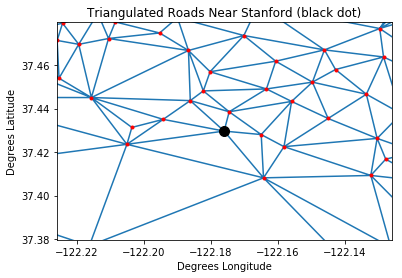

In [268]:
# Q13 
stanford_coords = location_dictionary['2607']['mean_coord']
plt.triplot(mean_coords[:,0], mean_coords[:,1], tri.simplices.copy())
plt.plot(mean_coords[:,0], mean_coords[:,1],'r.')
plt.plot(stanford_coords[0],stanford_coords[1],'k.',ms=20)
plt.xlim((stanford_coords[0]-0.05,stanford_coords[0]+0.05))
plt.ylim((stanford_coords[1]-0.05,stanford_coords[1]+0.05))
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Triangulated Roads Near Stanford (black dot)')
plt.show()

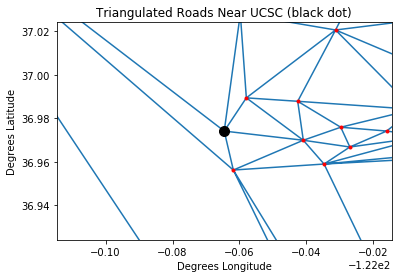

In [269]:
#Q13 Continued
ucsc_coords = location_dictionary['1968']['mean_coord']
plt.triplot(mean_coords[:,0], mean_coords[:,1], tri.simplices.copy())
plt.plot(mean_coords[:,0], mean_coords[:,1],'r.')
plt.plot(ucsc_coords[0],ucsc_coords[1],'k.',ms=20)
plt.xlim((ucsc_coords[0]-0.05,ucsc_coords[0]+0.05))
plt.ylim((ucsc_coords[1]-0.05,ucsc_coords[1]+0.05))
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Triangulated Roads Near UCSC (black dot)')
plt.show()

In [383]:
#Q14 Prune the graph
triangulated_time_graph = {}
THRESH = 60*12

for triangle_idx in tri.simplices:
    triangle = [uber_gcc_ids[triangle_idx[0]], uber_gcc_ids[triangle_idx[1]], uber_gcc_ids[triangle_idx[2]]]
    add_travel_time_edge(triangulated_time_graph, triangle, THRESH)
    
len(triangulated_time_graph)

5074

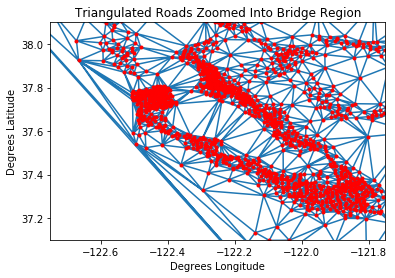

In [384]:
#Q14 Plot the original region near the bay
plt.triplot(mean_coords[:,0], mean_coords[:,1], tri.simplices.copy())
plt.plot(mean_coords[:,0], mean_coords[:,1],'r.')
plt.ylim((37.6-0.5,37.6+0.5))
plt.xlim((-122.25-0.5,-122.25+0.5))
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Triangulated Roads Zoomed Into Bridge Region')
plt.show()

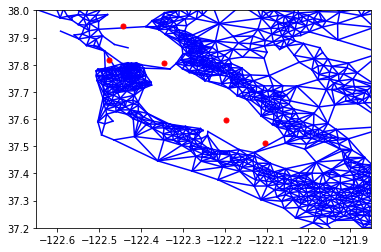

In [385]:
#Q15 Plot the pruned graph

plt.figure()
counter = 0
for edges in triangulated_time_graph.keys():
    coords1 = location_dictionary[str(edges[0])]['mean_coord']
    coords2 = location_dictionary[str(edges[1])]['mean_coord']
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')
plt.ylim((37.6-0.4,37.6+0.4))
plt.xlim((-122.25-0.4,-122.25+0.4))

bridge1 = [(-122.475+-122.479)/2, (37.806+37.83)/2]
bridge2 = [(-122.501+-122.387)/2, (37.956+37.93)/2]
bridge3 = [(-122.273+-122.122)/2, (37.563+37.627)/2]
bridge4 = [(-122.142+-122.067)/2, (37.486+37.54)/2]
bridge5 = [(-122.388+-122.302)/2, (37.788+37.825)/2]

bridges = np.array([bridge1,bridge2,bridge3,bridge4,bridge5])
plt.plot(bridges[:,0],bridges[:,1],'r.',ms=10)
plt.show()

In [386]:
#Q15 - Generate the pruned graph as a text file to be read into R
with open('pruned_triangulated_graph.txt','w') as f:
    for loc_pairs in triangulated_time_graph.keys():
        flow = get_flow(loc_pairs[0],loc_pairs[1], uber_gcc_graph, location_dictionary)
        if flow > 0:
            string = '{} {} {:.2f}\n'.format(int(loc_pairs[0]),int(loc_pairs[1]),flow)
            f.write(string)
        

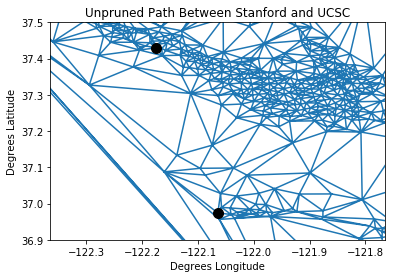

In [409]:
#Q15 Continued
stanford_coords = location_dictionary['2607']['mean_coord']
ucsc_coords = location_dictionary['1968']['mean_coord']
plt.triplot(mean_coords[:,0], mean_coords[:,1], tri.simplices.copy())
plt.plot(ucsc_coords[0],ucsc_coords[1],'k.',ms=20)
plt.plot(stanford_coords[0],stanford_coords[1],'k.',ms=20)
plt.xlim((ucsc_coords[0]-0.3,ucsc_coords[0]+0.3))
plt.ylim((37.2-0.3,37.2+0.3))
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Unpruned Path Between Stanford and UCSC')
plt.show()

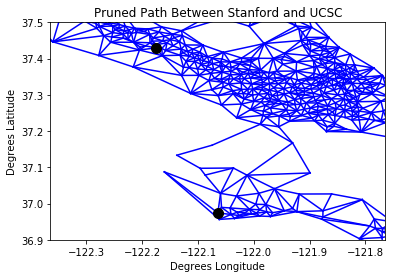

In [408]:
#Q15 Continued
stanford_coords = location_dictionary['2607']['mean_coord']
ucsc_coords = location_dictionary['1968']['mean_coord']
for edges in triangulated_time_graph.keys():
    coords1 = location_dictionary[str(edges[0])]['mean_coord']
    coords2 = location_dictionary[str(edges[1])]['mean_coord']
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')
plt.plot(ucsc_coords[0],ucsc_coords[1],'k.',ms=20)
plt.plot(stanford_coords[0],stanford_coords[1],'k.',ms=20)
plt.xlim((ucsc_coords[0]-0.3,ucsc_coords[0]+0.3))
plt.ylim((37.2-0.3,37.2+0.3))
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Pruned Path Between Stanford and UCSC')
plt.show()

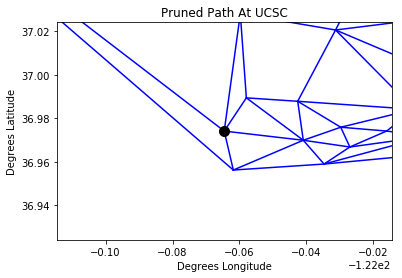

In [410]:
#Q15 Continued
stanford_coords = location_dictionary['2607']['mean_coord']
ucsc_coords = location_dictionary['1968']['mean_coord']
for edges in triangulated_time_graph.keys():
    coords1 = location_dictionary[str(edges[0])]['mean_coord']
    coords2 = location_dictionary[str(edges[1])]['mean_coord']
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')
plt.plot(ucsc_coords[0],ucsc_coords[1],'k.',ms=20)
plt.xlim((ucsc_coords[0]-0.05,ucsc_coords[0]+0.05))
plt.ylim((ucsc_coords[1]-0.05,ucsc_coords[1]+0.05))
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Pruned Path At UCSC')
plt.show()

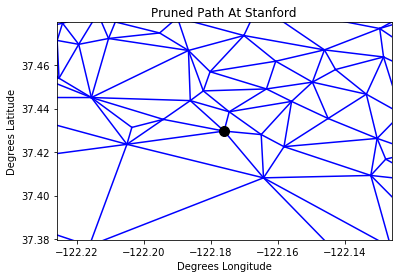

In [411]:
#Q15 Continued
stanford_coords = location_dictionary['2607']['mean_coord']
ucsc_coords = location_dictionary['1968']['mean_coord']
for edges in triangulated_time_graph.keys():
    coords1 = location_dictionary[str(edges[0])]['mean_coord']
    coords2 = location_dictionary[str(edges[1])]['mean_coord']
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')
plt.plot(stanford_coords[0],stanford_coords[1],'k.',ms=20)
plt.xlim((stanford_coords[0]-0.05,stanford_coords[0]+0.05))
plt.ylim((stanford_coords[1]-0.05,stanford_coords[1]+0.05))
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Pruned Path At Stanford')
plt.show()